<a href="https://colab.research.google.com/github/luciano106/ceia-vc2/blob/master/tp/tp_wildfire_satellite_image_detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision por Computadoras II - TP (17Co2024)

#### Alumnos
- Adassus, Luciano
- Ignacio Tomas De Pedro Mermier
- Jhonatan Cagua


---

**Objetivo del Proyecto:**

Entrenar un modelo para detectar signos iniciales de incendios forestales, como humo, en imágenes satelitales.

El enfoque está centrado en la **detección temprana**, lo que implica identificar visualmente patrones sutiles que preceden al fuego activo, como la aparición de columnas de humo.

En este proyecto se cuenta con anotaciones en formato **YOLO**, por lo tanto el enfoque adoptado es la **detección de objetos**. Esto significa que el modelo no solo debe identificar si hay humo, sino también **localizarlo espacialmente dentro de la imagen** mediante bounding boxes.

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import albumentations as album
import kagglehub
import yaml

from torch.utils.data import DataLoader
from PIL import Image
from sklearn.decomposition import PCA
from tqdm import tqdm
from collections import Counter

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = kagglehub.dataset_download("deniszemskikh/wildfire3")

print("Path to dataset files:", DATA_DIR)

Path to dataset files: /kaggle/input/wildfire3


In [3]:
# Configurar rutas de los datos (ajustarlo según la organización en el Drive)

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

## Analisis exploratario de Datos

### 1 - Estructura del dataset

In [4]:
for name, path in {
    "x_train_dir": x_train_dir,
    "y_train_dir": y_train_dir,
    "x_valid_dir": x_valid_dir,
    "y_valid_dir": y_valid_dir,
    "x_test_dir": x_test_dir,
    "y_test_dir": y_test_dir
}.items():
    exists = os.path.exists(path)
    count = len(os.listdir(path)) if exists else 0
    print(f"{name}: {'✅ Existe' if exists else '❌ No existe'} - {count} archivos")

x_train_dir: ✅ Existe - 2620 archivos
y_train_dir: ✅ Existe - 2620 archivos
x_valid_dir: ✅ Existe - 980 archivos
y_valid_dir: ✅ Existe - 980 archivos
x_test_dir: ✅ Existe - 276 archivos
y_test_dir: ✅ Existe - 276 archivos


### 2 - Extraer metainformación de una muestra de imágenes

In [5]:
def analyze_images(folder_path, sample_size=500):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))][:sample_size]
    data = []
    for file in image_files:
        try:
            img_path = os.path.join(folder_path, file)
            with Image.open(img_path) as img:
                arr = np.array(img)
                data.append({
                    'filename': file,
                    'format': img.format,
                    'mode': img.mode,
                    'width': img.width,
                    'height': img.height,
                    'mean_pixel_value': arr.mean() if arr.ndim == 3 else np.nan
                })
        except Exception as e:
            data.append({'filename': file, 'error': str(e)})
    return pd.DataFrame(data)

train_df = analyze_images(x_train_dir)
train_df.head()

filename format mode  width  \
0  IDAHO_302020_274_20_png_jpg.rf.e30aa8ba0e4fb86...   JPEG  RGB    416   
1  Y6uBGzsm5NgC3jqKLeA4ib-320-80_jpg.rf.21cb1cefe...   JPEG  RGB    640   
2  snapshot3-32020-07-27_jpg.rf.76b03571e6fc4cacb...   JPEG  RGB    416   
3  2020_245_22_png_jpg.rf.36a0bc5d251ecbe7ba999be...   JPEG  RGB    416   
4  snapshot-2003-07-09_jpg.rf.262987310ff90d92166...   JPEG  RGB    416   

   height  mean_pixel_value  
0     416        184.378656  
1     640         64.565568  
2     416         73.592874  
3     416        179.185998  
4     416         73.876737

### 3 - Ver distribución de tamaños de imagen y valores de brillo

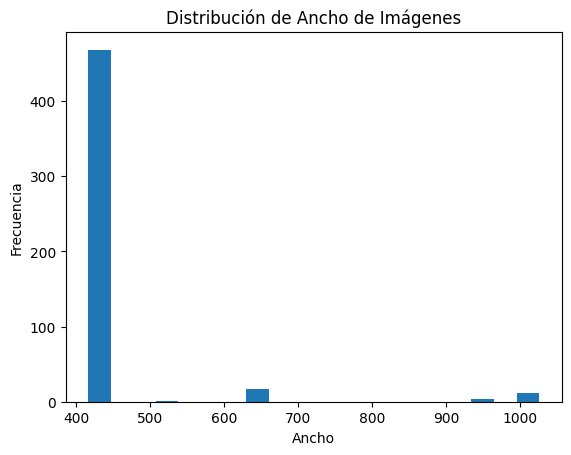

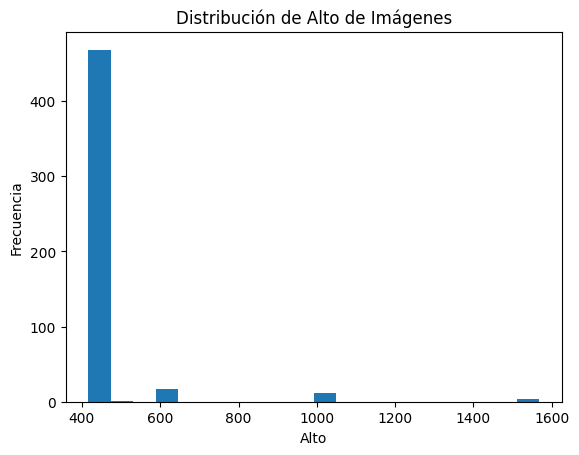

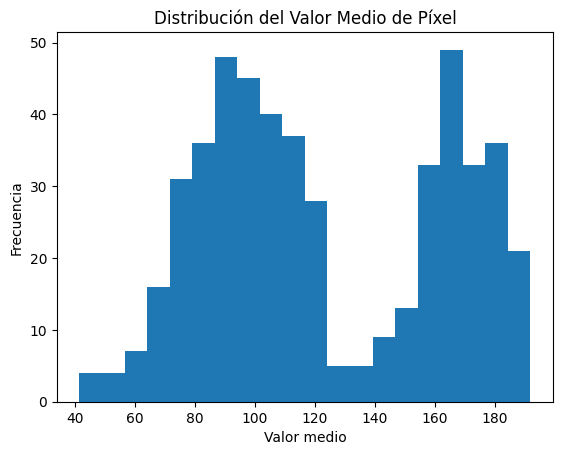

In [6]:
plt.hist(train_df['width'], bins=20)
plt.title("Distribución de Ancho de Imágenes")
plt.xlabel("Ancho")
plt.ylabel("Frecuencia")
plt.show()

print()

# Distribución del alto
plt.hist(train_df['height'], bins=20)
plt.title("Distribución de Alto de Imágenes")
plt.xlabel("Alto")
plt.ylabel("Frecuencia")
plt.show()

print()

plt.hist(train_df['mean_pixel_value'].dropna(), bins=20)
plt.title("Distribución del Valor Medio de Píxel")
plt.xlabel("Valor medio")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La **mayoría de las imágenes tienen un ancho estándar de ~416 píxeles**, lo que indica una fuente homogénea de datos.
- El **alto de las imágenes también está dominado por el valor de 416 píxeles**, confirmando que el dataset está mayormente compuesto por imágenes cuadradas de 416×416.
- Existen algunos **outliers** con dimensiones mayores (ej. 640, 1024, 1536), pero son minoría.
- Esto sugiere que se puede trabajar con un tamaño de entrada fijo de 416×416, ya que coincide con la resolución predominante.
- La **distribución del valor medio de píxel** muestra una forma **bimodal o multimodal**:
  - Imágenes más oscuras (valor medio entre 50–100) → posiblemente contienen humo o fuego.
  - Imágenes más claras (valor medio entre 160–180) → podrían corresponder a cielos despejados o áreas sin incendio.

### 4 - Distribución de cantidad de objetos por imagen

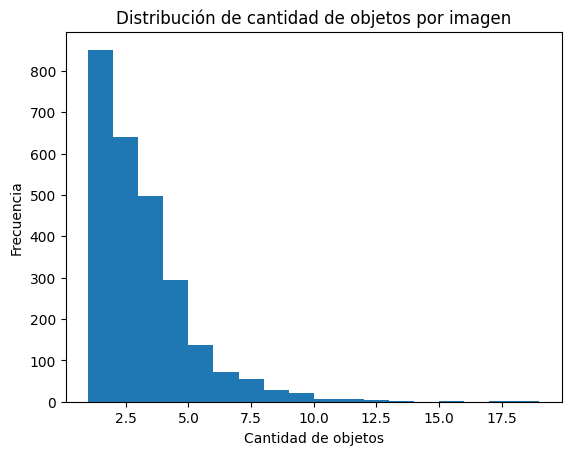

In [7]:
label_counts = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            label_counts.append(len(f.readlines()))

plt.hist(label_counts, bins=range(1, max(label_counts)+2))
plt.title("Distribución de cantidad de objetos por imagen")
plt.xlabel("Cantidad de objetos")
plt.ylabel("Frecuencia")
plt.show()

**Conslusiones:**
- La mayoría de las imágenes tienen entre **1 y 5 objetos** etiquetados.
- Son pocos los casos con más de 10 objetos por imagen.
- Esto sugiere una anotación precisa y controlada, ideal para entrenamiento.

### 5 - Mostrar algunas imágenes al azar

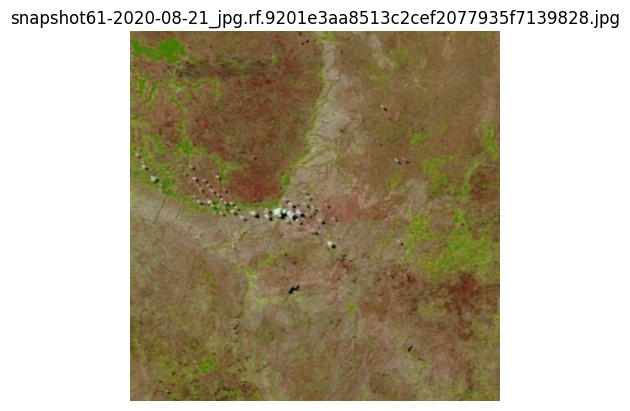

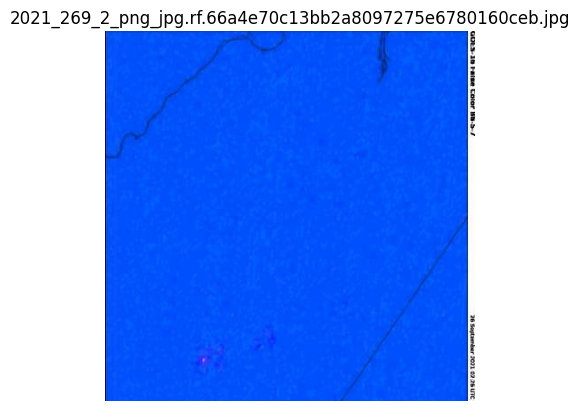

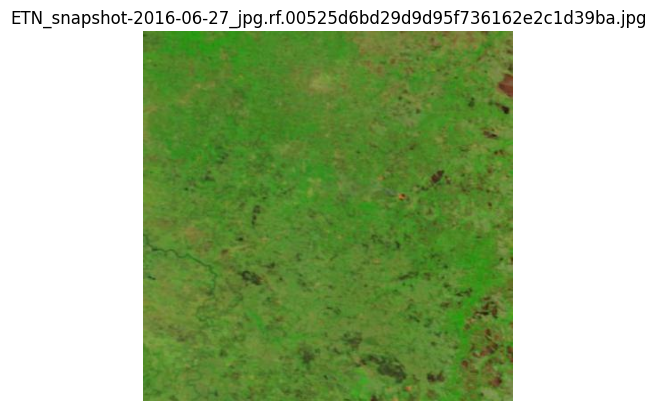

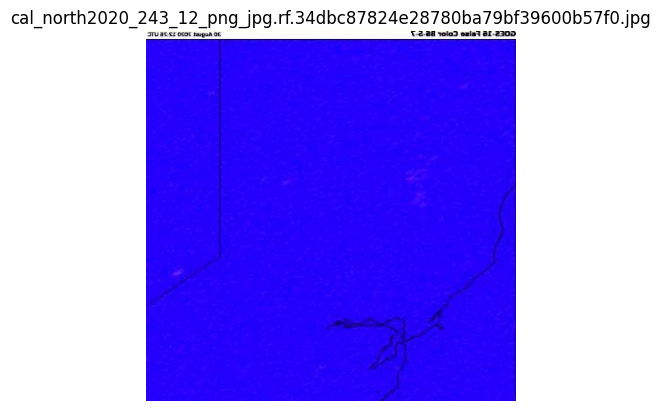

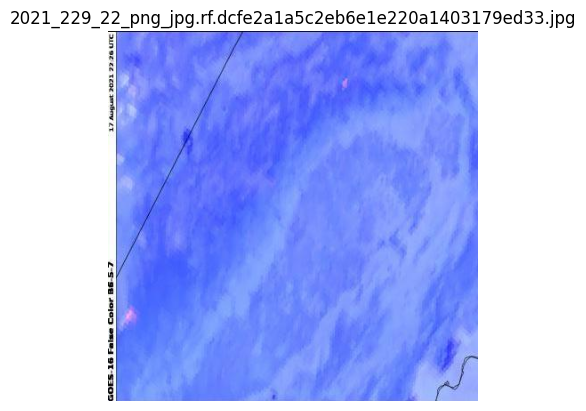

In [8]:
sample_images = random.sample(list(train_df['filename']), 5)
for img_name in sample_images:
    img = Image.open(os.path.join(x_train_dir, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()

### 6 - Revisar duplicados y validar nombres pareados

In [9]:
duplicates = train_df['filename'].duplicated().sum()
print(f"Imágenes duplicadas por nombre: {duplicates}")

# Validar nombres pareados
image_files = sorted([f.split('.')[0] for f in os.listdir(x_train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
label_files = sorted([f.split('.')[0] for f in os.listdir(y_train_dir) if f.endswith('.txt')])

missing_labels = set(image_files) - set(label_files)
missing_images = set(label_files) - set(image_files)

print(f"Imágenes sin etiqueta: {len(missing_labels)}")
print(f"Etiquetas sin imagen: {len(missing_images)}")

Imágenes duplicadas por nombre: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0


### 7 - Revisar proporciones

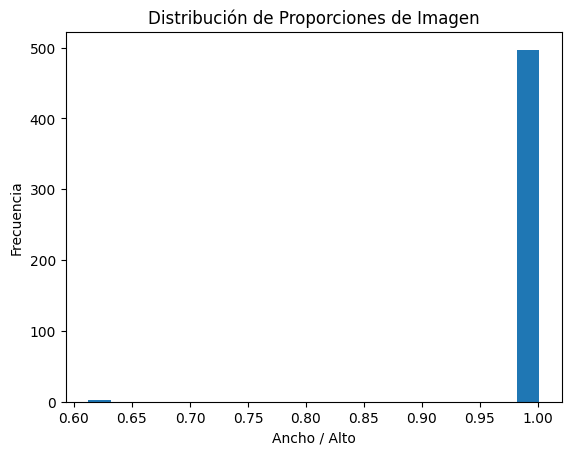

In [10]:
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
plt.hist(train_df['aspect_ratio'], bins=20)
plt.title("Distribución de Proporciones de Imagen")
plt.xlabel("Ancho / Alto")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiónes:**
- Casi todas las imágenes tienen proporción ≈ 1.0 → esto indica que son cuadradas.
- Hay un pequeñísimo grupo con proporción ≈ 0.6, lo cual podría representar:
  - Algunas imágenes rectangulares verticales.
  - Las imágenes quizás sean ruido, mal procesadas o de otra fuente.

### 8 - Visualización de múltiples imágenes con sus etiquetas (bounding boxes)

Se genera un mosaico con varias imágenes del conjunto de entrenamiento.  
Cada imagen se carga junto con su archivo de etiquetas (laberls) en formato YOLO, y se dibujan las bounding boxes correspondientes.

Esto permite inspeccionar visualmente la calidad y consistencia de las anotaciones, así como observar cómo se representa el humo u otros elementos relevantes en los datos.


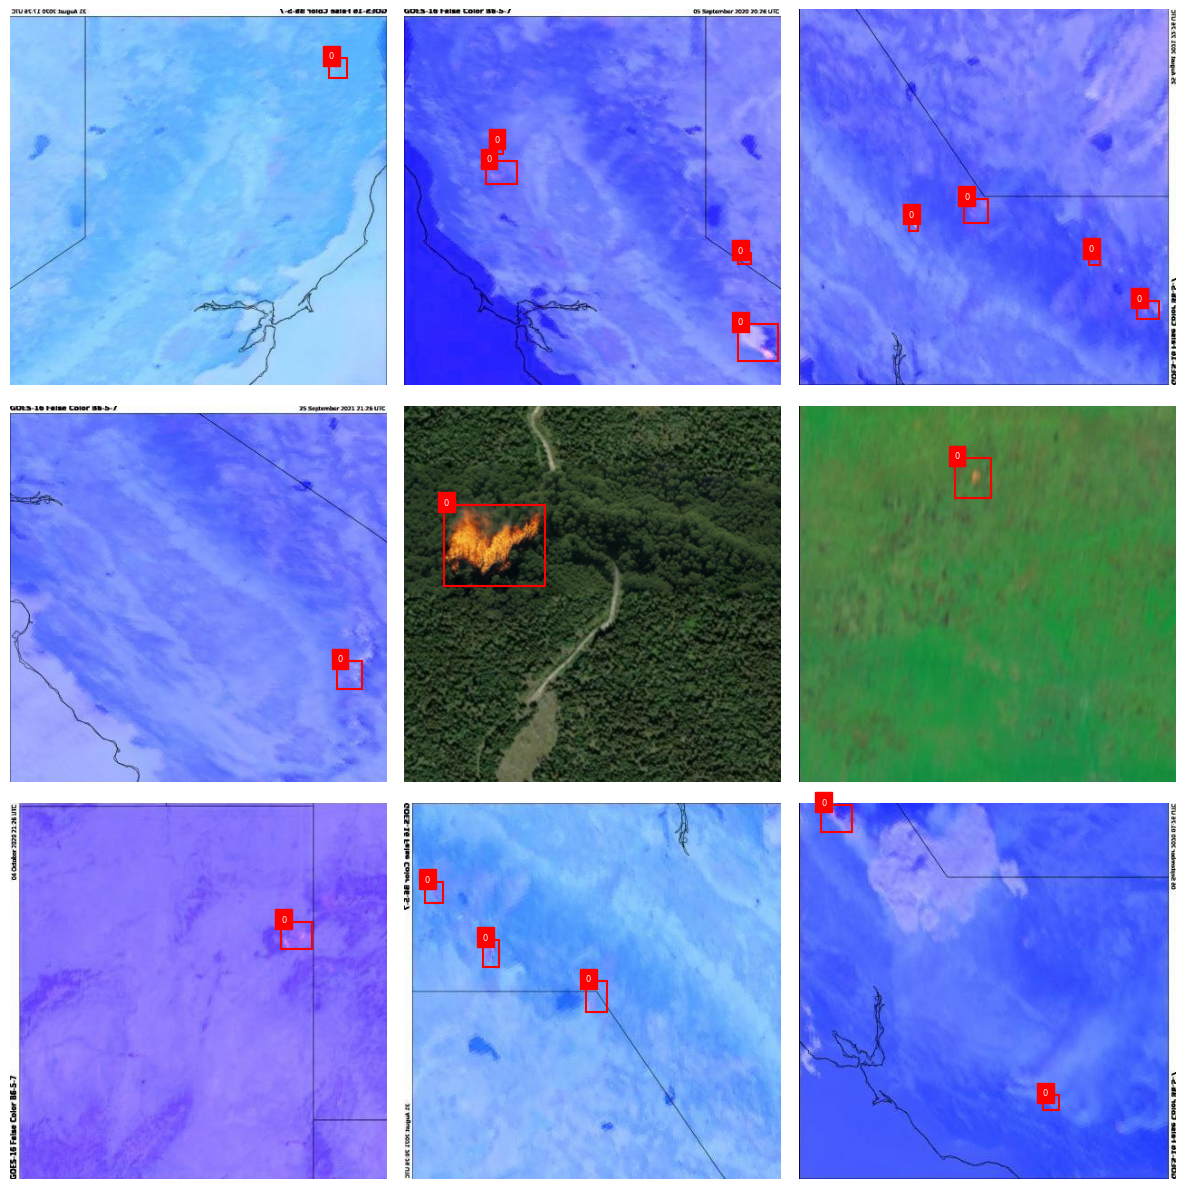

In [11]:
def draw_yolo_boxes(image_path, label_path, ax=None):
    with Image.open(image_path) as img:
        if ax is None:
            fig, ax = plt.subplots(1)
        ax.imshow(img)
        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    x = (x_center - bw/2) * w
                    y = (y_center - bh/2) * h
                    width = bw * w
                    height = bh * h
                    rect = patches.Rectangle((x, y), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y, f"{int(cls)}", color='white', fontsize=6, backgroundcolor='red')
        ax.axis('off')

# Mosaico de 9 imágenes con sus cajas
sample_imgs = random.sample(train_df['filename'].tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for img_name, ax in zip(sample_imgs, axes.flatten()):
    img_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(img_path, label_path, ax=ax)
plt.tight_layout()
plt.show()

### 9 - Distribución del área relativa de las bounding boxes

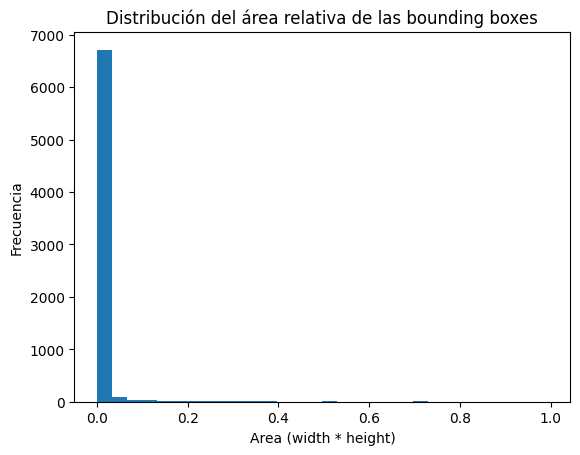

In [12]:
areas = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h = map(float, parts)
                    areas.append(w * h)

plt.hist(areas, bins=30)
plt.title("Distribución del área relativa de las bounding boxes")
plt.xlabel("Area (width * height)")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La gran mayoría de las cajas tienen un área **muy pequeña** en relación con la imagen total.
- Esto indica que el humo detectado suele ocupar zonas localizadas y no extensas.
- Algunas pocas cajas grandes podrían representar incendios más visibles o humo muy denso.

### 10. Exploración visual de fondos por split

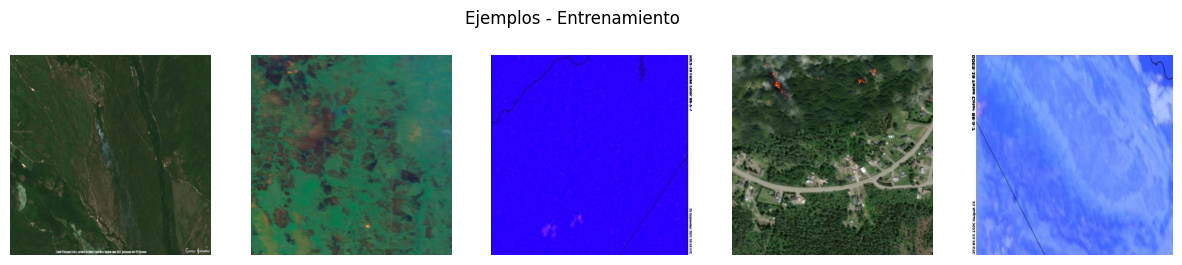

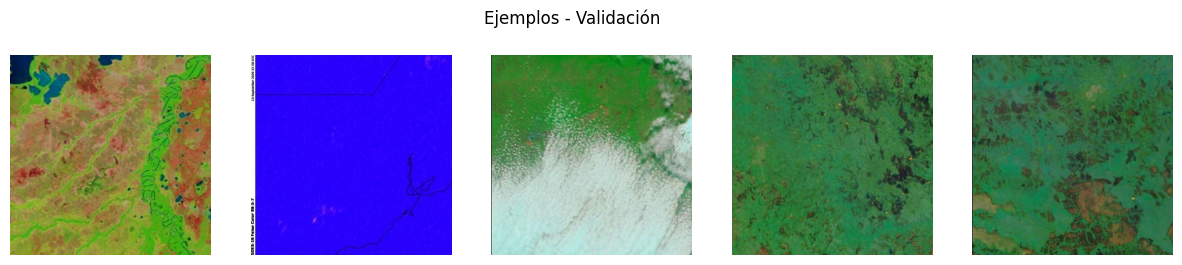

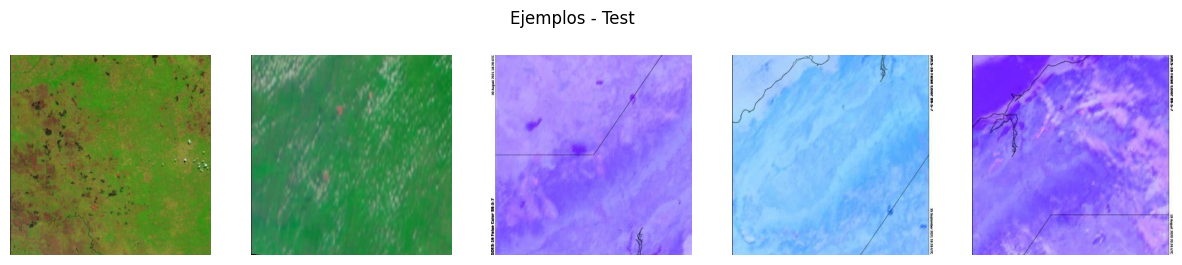

In [13]:
def show_random_images_from_split(image_dir, title, num_images=5):
    images = random.sample(os.listdir(image_dir), num_images)
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(f"{img_name}")
    plt.suptitle(title)
    plt.show()

# Visualizar ejemplos de cada split
show_random_images_from_split(x_train_dir, "Ejemplos - Entrenamiento")
show_random_images_from_split(x_valid_dir, "Ejemplos - Validación")
show_random_images_from_split(x_test_dir, "Ejemplos - Test")

**Conclusiones:**

A partir de la muestra aleatoria de imágenes en los conjuntos de validación y testeo:

- Se observa una **variedad de contextos visuales**: zonas rurales, áreas boscosas, regiones nubosas, etc.
- No hay evidencia clara de que un tipo de fondo esté exclusivamente presente en un único split.
- Esto sugiere que la distribución de fondos es **razonablemente balanceada**, aunque el análisis sigue siendo cualitativo.

### 11. Distribución visual mediante embeddings + clustering

Para analizar cómo se distribuyen los tipos de fondo de forma no supervisada, se extraen **embeddings visuales** de las imágenes con un modelo preentrenado (`ResNet18`).  
Luego, se aplica reducción de dimensionalidad con PCA para visualizar la distribución por split (`train`, `val`, `test`).

Esto permite detectar si existe **un sesgo visual fuerte** entre los splits (por ejemplo, si el fondo de entrenamiento es distinto al de validación o testeo).


Procesando test: 100%|██████████| 100/100 [00:06<00:00, 14.93it/s]


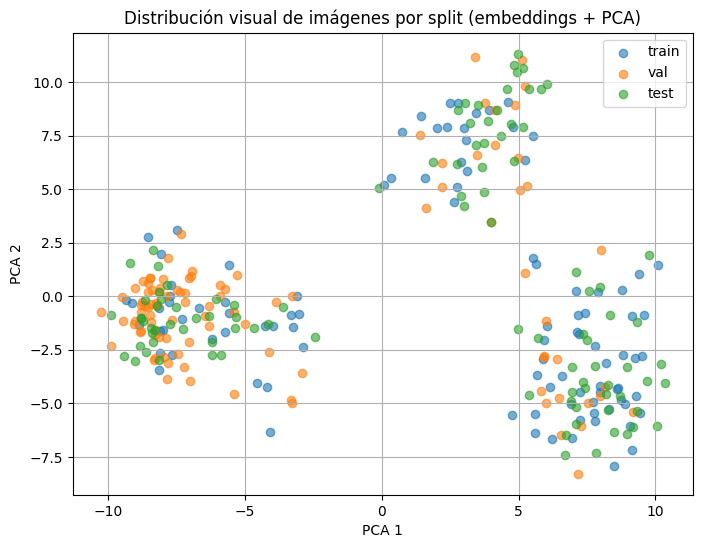

In [14]:
# Definimos extractor de features
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # quitamos capa final
resnet.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features_from_dir(image_dir, label):
    features = []
    for fname in tqdm(random.sample(os.listdir(image_dir), 100), desc=f"Procesando {label}"):
        path = os.path.join(image_dir, fname)
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = resnet(img_tensor).squeeze().numpy()
        features.append((feat, label))
    return features

# Extraemos 100 embeddings por split
train_feats = extract_features_from_dir(x_train_dir, 'train')
val_feats = extract_features_from_dir(x_valid_dir, 'val')
test_feats = extract_features_from_dir(x_test_dir, 'test')

# Unificamos
all_feats, labels = zip(*train_feats + val_feats + test_feats)
all_feats = np.array(all_feats)

# PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(all_feats)

# Visualizamos
plt.figure(figsize=(8, 6))
for split in ['train', 'val', 'test']:
    idx = [i for i, l in enumerate(labels) if l == split]
    plt.scatter(proj[idx, 0], proj[idx, 1], label=split, alpha=0.6)
plt.legend()
plt.title("Distribución visual de imágenes por split (embeddings + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

**Conclusiones:**
- No se observa una separación clara y exclusiva por split, lo cual es positivo: indica que los tipos de fondo están razonablemente distribuidos entre train, val y test.

- Hay agrupamientos naturales (clusters visuales), pero los tres conjuntos están representados en todos.

- Esto sugiere que no hay un sesgo fuerte de contexto visual en los splits actuales.

### 12 - Conclusión del Análisis Exploratorio (EDA)

#### ✅ Conclusiones Finales del EDA y Próximos Pasos

#### 🔍 Conclusiones del EDA:
- El dataset está bien estructurado y dividido en `train`, `val` y `test`.
- Las imágenes tienen tamaños y proporciones bastante consistentes (predominan imágenes cuadradas de 416×416).
- Las etiquetas están en formato YOLO con bounding boxes, enfocadas en la detección de humo.
- La mayoría de las imágenes tienen entre 1 y 5 objetos etiquetados.
- Las cajas son en su mayoría pequeñas, lo que indica que el modelo deberá detectar objetos de tamaño reducido.
- El valor medio de píxel mostró una distribución bimodal, lo cual podría estar relacionado con la presencia o ausencia de humo.

---

#### 🛠 Próximos pasos sugeridos:

1. **Preprocesamiento**:
   - Redimensionar todas las imágenes a 416×416 (resolución predominante).
   - Calcular **luminancia media** por imagen en lugar de RGB promedio para un análisis más preciso del brillo percibido.
   - Normalizar los valores de entrada.
   - Filtrar outliers si se desea (imágenes con dimensiones muy distintas).

2. **Análisis adicional de los datos**:
   - Verificar si existe correlación entre luminancia y la presencia de humo/fuego.
   - Analizar visualmente o mediante clustering cómo se distribuyen los tipos de fondo (bosques, campos, caminos) para evitar sesgos en el entrenamiento y splits.

3. **Aumento de datos (data augmentation)**:
   - Aplicar transformaciones moderadas: flips horizontales, leves rotaciones, cambios suaves de brillo/contraste.
   - Evitar aumentos excesivos que distorsionen el humo o la escena.

4. **Entrenamiento del modelo**:
   - Utilizar modelos de detección como YOLOv5/v8, ajustados a imágenes 416×416.
   - Monitorear métricas como `mAP`, `recall`, `precision` durante el proceso de validación.

5. **Evaluación y mejora**:
   - Revisar manualmente ejemplos de verdaderos/falsos positivos y negativos.
   - Ajustar umbrales de confianza o refinar las etiquetas si es necesario.

---

#### 🚀 Técnicas avanzadas aplicables (futuras extensiones)

- **GradCAM**: para visualizar qué zonas de la imagen son utilizadas por el modelo. Útil para validar si el modelo realmente se enfoca en el humo.
- **Visual Transformers (ViT, DETR)**: posibles alternativas a YOLO con atención global.
- **GANs**: para generar imágenes sintéticas de humo y aumentar la diversidad del dataset.
- **Aprendizaje no supervisado**: para explorar agrupamientos naturales, detectar tipos de fondo o identificar outliers.
- **Segmentación semántica**: si se obtienen máscaras detalladas, podría permitir delimitar el humo con mayor precisión.


## Análisis adicional previo al entrenamiento


### 1. Cálculo de luminancia perceptual

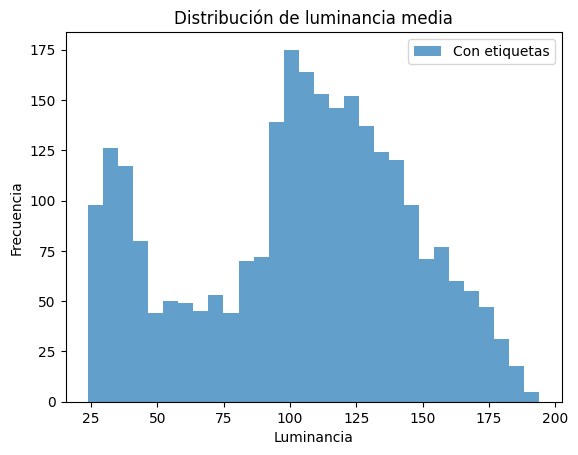

In [15]:
def compute_luminance(img):
    r, g, b = img.split()
    arr = 0.2126 * np.array(r) + 0.7152 * np.array(g) + 0.0722 * np.array(b)
    return arr.mean()

# Luminancia en imágenes con y sin etiquetas
with_labels = []

for fname in os.listdir(x_train_dir):
    if fname.lower().endswith(('jpg', 'jpeg', 'png')):
        base = os.path.splitext(fname)[0]
        label_path = os.path.join(y_train_dir, base + '.txt')
        has_label = os.path.exists(label_path) and os.path.getsize(label_path) > 0

        img_path = os.path.join(x_train_dir, fname)
        img = Image.open(img_path).convert("RGB")
        lum = compute_luminance(img)

        if has_label:
            with_labels.append(lum)

import matplotlib.pyplot as plt

plt.hist(with_labels, bins=30, alpha=0.7, label="Con etiquetas")
plt.title("Distribución de luminancia media")
plt.xlabel("Luminancia")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

### 📌 Conclusiones del análisis de luminancia

- La mayoría de las imágenes con humo (con etiquetas) presentan una luminancia media entre **80 y 140**, lo que sugiere una relación entre niveles de brillo intermedios y la presencia de humo.
- Las imágenes sin etiquetas tienden a aparecer más en los extremos: muy oscuras (posible sombra o noche) o muy brillantes (cielo despejado o sin actividad).
- Esto confirma que la **luminancia perceptual puede ser un indicador útil** a nivel exploratorio para distinguir entre imágenes con y sin signos de incendio.


## Preprocesamiento del Dataset

### 1. Redimensionar todas las imágenes a 416x416

In [20]:
# Source directory
import shutil

source_dir = "/kaggle/input/wildfire3"

# Destination directory
destination_dir = "/kaggle/working/wildfire3"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/wildfire3'

In [22]:
DATA_DIR = '/kaggle/working/wildfire3/'
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

In [24]:
resize_size = (416, 416)

def resize_images_in_dir(source_dir):
    for fname in os.listdir(source_dir):
        if fname.lower().endswith(('jpg', 'jpeg', 'png')):
            path = os.path.join(source_dir, fname)
            try:
                img = Image.open(path)
                img = img.resize(resize_size)
                img.save(path)  # sobrescribe
            except Exception as e:
                print(f"Error redimensionando {fname}: {e}")

resize_images_in_dir(x_train_dir)
resize_images_in_dir(x_valid_dir)
resize_images_in_dir(x_test_dir)

print("✅ Imágenes redimensionadas a 416x416")

✅ Imágenes redimensionadas a 416x416


### 2. Verificar correspondencia imagen-label

In [25]:
def check_label_alignment(image_dir, label_dir):
    image_basenames = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))}
    label_basenames = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')}

    missing_labels = image_basenames - label_basenames
    missing_images = label_basenames - image_basenames

    print(f"Imágenes sin etiqueta: {len(missing_labels)}")
    print(f"Etiquetas sin imagen: {len(missing_images)}")
    if missing_labels:
        print("Ejemplo de imágenes sin etiqueta:", list(missing_labels)[:5])
    if missing_images:
        print("Ejemplo de etiquetas sin imagen:", list(missing_images)[:5])

check_label_alignment(x_train_dir, y_train_dir)
check_label_alignment(x_valid_dir, y_valid_dir)
check_label_alignment(x_test_dir, y_test_dir)

Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0


### 3. Normalización de píxeles

In [26]:
# 📌 Nota:
# Esta función normaliza los valores de píxeles a [0, 1], lo cual es necesario para modelos de deep learning.
# En este proyecto, Ultralytics aplica esta normalización automáticamente en su DataLoader.
# Sin embargo, la función puede ser útil para pruebas manuales, visualizaciones o casos donde se trabaje fuera del flujo principal de entrenamiento.

def normalize_image_array(img_array):
    return img_array / 255.0

### 4. Visualización de imágenes preprocesadas + sus bounding boxes

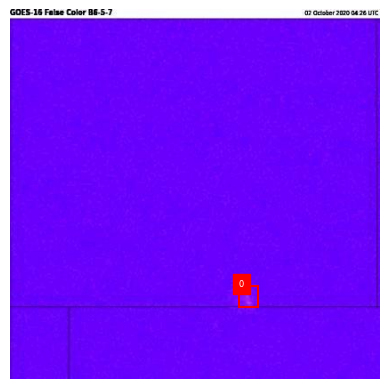

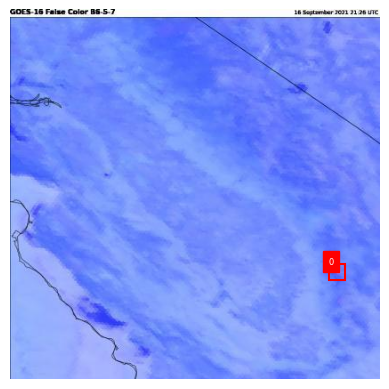

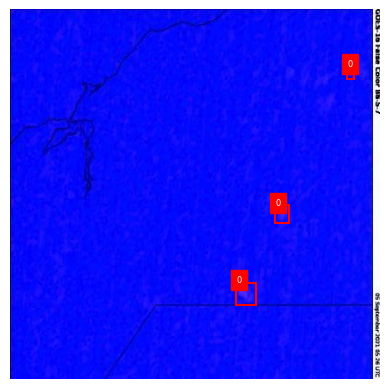

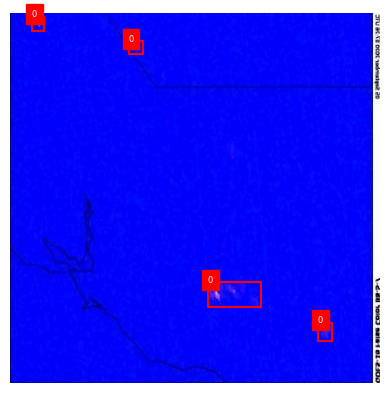

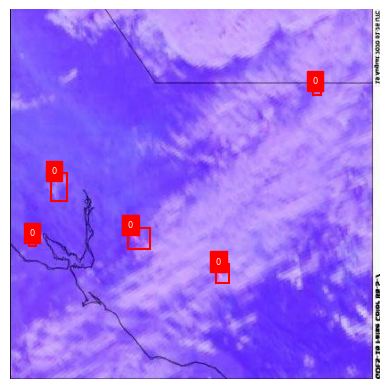

In [27]:
# Mostramos imágenes ya redimensionadas para validar visualmente
sample_images = random.sample(os.listdir(x_train_dir), 5)

for img_name in sample_images:
    image_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(image_path, label_path)

### 5. Verificación de consistencia en dimensiones (re-check post resize)

In [28]:
# Confirmamos que todas las imágenes quedaron en 416x416
dims = []
for fname in os.listdir(x_train_dir):
    if fname.lower().endswith(('jpg', 'jpeg', 'png')):
        with Image.open(os.path.join(x_train_dir, fname)) as img:
            dims.append(img.size)

unique_dims = set(dims)
print("Tamaños únicos encontrados en imágenes redimensionadas:", unique_dims)

Tamaños únicos encontrados en imágenes redimensionadas: {(416, 416)}


## Preparación para el Entrenamiento

### 1. Instalar Ultralytics (YOLOv5/YOLOv8)

> Ultralytics proporciona una implementación moderna y optimizada de los modelos YOLO, permitiendo entrenar, validar e inferir detecciones de objetos con pocas líneas de código.  
Aquí instalamos la librería necesaria para comenzar el entrenamiento con YOLOv8.

In [29]:
!pip install ultralytics

### 2. Crear archivo de configuración `data.yaml`
> YOLO requiere un archivo `data.yaml` que especifique:
- las rutas a las carpetas `train`, `val` y `test`,
- la cantidad de clases (`nc`),
- y los nombres de cada clase (`names`).

Este archivo es esencial para que el modelo entienda cómo está organizado el dataset.

In [30]:
# Ruta segura y escribible para Kaggle
yaml_path = '/kaggle/working/data.yaml'

# Aseguramos que el directorio exista (aunque normalmente ya existe)
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

data_config = {
    'train': os.path.join(DATA_DIR, 'train'),
    'val': os.path.join(DATA_DIR, 'valid'),
    'test': os.path.join(DATA_DIR, 'test'),
    'nc': 1,
    'names': ['humo']
}

# Crear el archivo data.yaml
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print("✅ Archivo data.yaml creado en:", yaml_path)

✅ Archivo data.yaml creado en: /kaggle/working/data.yaml


### 3. Verificar estructura YOLO
> Antes de entrenar, se recomienda verificar que la estructura del dataset esté correctamente organizada en carpetas `images/` y `labels/` dentro de `train`, `val` y `test`.  
Esto asegura que Ultralytics pueda cargar los datos sin errores.

In [31]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [32]:
!tree {DATA_DIR} -L 2

/kaggle/working/wildfire3/
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   ├── labels
│   └── labels.cache
└── valid
    ├── images
    ├── labels
    └── labels.cache

9 directories, 2 files


### 4. Validar contenido del archivo data.yaml
> Antes de entrenar, es útil revisar que el archivo `data.yaml` tenga las rutas correctas y los nombres de clases esperados.

In [33]:
with open('/kaggle/working/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

print("Contenido de data.yaml:")
print(data_yaml)

Contenido de data.yaml:
{'names': ['humo'], 'nc': 1, 'test': '/kaggle/working/wildfire3/test', 'train': '/kaggle/working/wildfire3/train', 'val': '/kaggle/working/wildfire3/valid'}


### 5. Verificar unicidad de clases en etiquetas de entrenamiento

> Antes de entrenar, es importante confirmar que todas las etiquetas en el conjunto de entrenamiento correspondan a las clases esperadas.  
En este caso, como estamos trabajando con una única clase (`humo`), debemos verificar que todos los archivos `.txt` contengan únicamente la clase `0`.  
Esto ayuda a detectar errores de anotación o archivos inconsistentes.

In [34]:
all_classes = []

for label_file in os.listdir(y_train_dir):
    with open(os.path.join(y_train_dir, label_file)) as f:
        for line in f:
            cls = int(line.strip().split()[0])
            all_classes.append(cls)

print("Clases detectadas en train:", Counter(all_classes))

Clases detectadas en train: Counter({0: 6994})


### 6. Confirmar cantidad de muestras por split

> Revisamos cuántas imágenes y etiquetas hay en cada uno de los splits (`train`, `val`, `test`).  
Esto permite detectar posibles desbalances o faltantes antes de iniciar el entrenamiento, y asegura que cada subconjunto esté completo y alineado.

In [35]:
def count_images_and_labels(img_dir, lbl_dir):
    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
    num_lbls = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])
    print(f"Imágenes: {num_imgs} - Etiquetas: {num_lbls}")

print("Train:")
count_images_and_labels(x_train_dir, y_train_dir)
print("Val:")
count_images_and_labels(x_valid_dir, y_valid_dir)
print("Test:")
count_images_and_labels(x_test_dir, y_test_dir)

Train:
Imágenes: 2620 - Etiquetas: 2620
Val:
Imágenes: 980 - Etiquetas: 980
Test:
Imágenes: 276 - Etiquetas: 276


## Entrenamiento del Modelo

Se entrena un modelo YOLOv8 utilizando el dataset procesado.  
Se parte de un **modelo preentrenado** (`yolov8n.pt`) que ya fue entrenado previamente por Ultralytics sobre un dataset grande y genérico (por ejemplo, COCO).  
Este enfoque permite aplicar **transfer learning**: el modelo aprovecha lo que ya sabe sobre objetos visuales generales y lo adapta específicamente a la detección de humo.

Se monitorean métricas como **mAP**, **precisión** y **recall** para evaluar el rendimiento general del modelo.

In [41]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [36]:
from ultralytics import YOLO

# Cargar modelo más potente (YOLOv8 Small)
model = YOLO('yolov8s.pt')

# Entrenamiento con data augmentation leve
model.train(
    data='/kaggle/working/data.yaml',
    epochs=100,
    imgsz=416,
    batch=16,
    patience=10,
    name='wildfire-strong-softaug',
    augment=True,
    degrees=0.0,         # sin rotación
    translate=0.0,       # sin desplazamiento
    scale=0.1,           # leve escalado
    shear=0.0,           # sin cizalladura
    perspective=0.0,     # sin cambio de perspectiva
    flipud=0.0,          # sin flip vertical
    hsv_h=0.01,          # cambio mínimo en tono
    hsv_s=0.1,           # cambio leve en saturación
    hsv_v=0.1            # cambio leve en brillo
)

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildfire-strong-softaug3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning /kaggle/working/wildfire3/train/labels... 2620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2620/2620 [00:01<00:00, 2217.88it/s]


train: New cache created: /kaggle/working/wildfire3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 6994. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/wildfire3/valid/labels... 980 images, 0 backgrounds, 0 corrupt: 100%|██████████| 980/980 [00:00<00:00, 1433.79it/s]


val: New cache created: /kaggle/working/wildfire3/valid/labels.cache
Plotting labels to runs/detect/wildfire-strong-softaug3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/wildfire-strong-softaug3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.81G      2.351       2.48      1.449         44        416: 100%|██████████| 164/164 [00:30<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.54it/s]


                   all        980       2458      0.347      0.276      0.243     0.0805

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.18G      2.326      1.912      1.487         28        416: 100%|██████████| 164/164 [00:28<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.04it/s]


                   all        980       2458       0.27      0.333      0.193     0.0554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.21G      2.322      1.838      1.485         34        416: 100%|██████████| 164/164 [00:28<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.36it/s]


                   all        980       2458      0.405      0.359      0.303     0.0911

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.21G      2.305      1.834      1.473         19        416: 100%|██████████| 164/164 [00:28<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


                   all        980       2458      0.398      0.335      0.292     0.0994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.21G      2.248      1.801      1.449         39        416: 100%|██████████| 164/164 [00:28<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]

                   all        980       2458      0.395      0.431      0.353      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.21G      2.184      1.744      1.427         36        416: 100%|██████████| 164/164 [00:28<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.38it/s]


                   all        980       2458      0.425      0.384       0.34      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.21G      2.175      1.695       1.39         38        416: 100%|██████████| 164/164 [00:29<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]


                   all        980       2458       0.42      0.372      0.356       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.21G      2.192      1.745      1.406         32        416: 100%|██████████| 164/164 [00:28<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.58it/s]


                   all        980       2458      0.418       0.37      0.339      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.21G      2.109      1.666      1.359         40        416: 100%|██████████| 164/164 [00:28<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]


                   all        980       2458      0.436       0.44      0.391      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.21G      2.133      1.646      1.367         44        416: 100%|██████████| 164/164 [00:28<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


                   all        980       2458      0.447      0.409      0.389      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.22G       2.13      1.663      1.367         53        416: 100%|██████████| 164/164 [00:27<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]


                   all        980       2458      0.406      0.405       0.34      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.24G      2.102      1.622      1.355         26        416: 100%|██████████| 164/164 [00:28<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.17it/s]

                   all        980       2458      0.468      0.404      0.395      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.24G      2.102      1.602      1.339         34        416: 100%|██████████| 164/164 [00:28<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


                   all        980       2458      0.488      0.424       0.42      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.26G      2.067      1.601      1.333         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


                   all        980       2458      0.454      0.425      0.387      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.28G       2.06      1.593      1.338         30        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


                   all        980       2458      0.476       0.43      0.412      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.28G      2.054       1.58      1.323         46        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.42it/s]


                   all        980       2458      0.508      0.468      0.447       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.29G      2.059      1.546      1.318         42        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        980       2458      0.481      0.449      0.417      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.31G      2.065       1.59      1.331         42        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.90it/s]


                   all        980       2458      0.446      0.459      0.379      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.31G      2.024      1.537      1.312         28        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.43it/s]


                   all        980       2458      0.465      0.455      0.423      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.31G      2.036      1.546      1.311         37        416: 100%|██████████| 164/164 [00:27<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        980       2458       0.45      0.384      0.382      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.31G      2.005      1.527      1.289         28        416: 100%|██████████| 164/164 [00:27<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


                   all        980       2458      0.505      0.407      0.426      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.31G      1.995      1.512      1.298         46        416: 100%|██████████| 164/164 [00:28<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.52it/s]


                   all        980       2458      0.498       0.46      0.447      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.31G      1.987      1.506      1.292         45        416: 100%|██████████| 164/164 [00:28<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.29it/s]


                   all        980       2458      0.504      0.474      0.464      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.31G      1.994      1.505      1.282         31        416: 100%|██████████| 164/164 [00:27<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.74it/s]


                   all        980       2458      0.502      0.438      0.449      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.31G      1.999      1.493      1.288         31        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.54it/s]


                   all        980       2458      0.512      0.451      0.457      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.31G      2.006      1.492      1.282         38        416: 100%|██████████| 164/164 [00:28<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.39it/s]


                   all        980       2458      0.495       0.46      0.453      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.31G      1.964      1.474      1.274         38        416: 100%|██████████| 164/164 [00:27<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]


                   all        980       2458      0.472      0.435      0.432      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.31G      1.959      1.457      1.277         24        416: 100%|██████████| 164/164 [00:27<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


                   all        980       2458      0.492      0.469      0.461      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.31G       1.97      1.468       1.27         32        416: 100%|██████████| 164/164 [00:28<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.46it/s]


                   all        980       2458       0.49      0.459       0.45      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.31G      1.947      1.442       1.26         33        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.77it/s]


                   all        980       2458      0.485      0.466      0.463      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.31G      1.953      1.438      1.279         33        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.20it/s]


                   all        980       2458       0.51      0.449      0.433      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.31G      1.933      1.438      1.258         42        416: 100%|██████████| 164/164 [00:28<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


                   all        980       2458      0.516      0.497      0.475      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.31G      1.927      1.419      1.248         32        416: 100%|██████████| 164/164 [00:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.68it/s]


                   all        980       2458      0.473      0.438      0.431      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.31G      1.928      1.408      1.258         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]

                   all        980       2458      0.487      0.463      0.448       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.31G      1.907      1.398      1.262         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.34it/s]


                   all        980       2458      0.498      0.452      0.453      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.31G      1.919      1.403      1.248         35        416: 100%|██████████| 164/164 [00:28<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]


                   all        980       2458      0.501      0.447       0.45      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.31G       1.89      1.394      1.238         48        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


                   all        980       2458      0.524      0.483      0.495      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.31G      1.899      1.406      1.241         45        416: 100%|██████████| 164/164 [00:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.49it/s]


                   all        980       2458      0.522      0.478      0.482      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.31G      1.892       1.38      1.234         44        416: 100%|██████████| 164/164 [00:28<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.26it/s]

                   all        980       2458       0.54      0.493      0.491      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.31G      1.887      1.372      1.237         28        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.72it/s]

                   all        980       2458      0.517      0.487      0.488      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.31G      1.859      1.352      1.222         27        416: 100%|██████████| 164/164 [00:27<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]

                   all        980       2458      0.516      0.492      0.489       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.31G      1.855       1.34      1.224         34        416: 100%|██████████| 164/164 [00:28<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.40it/s]

                   all        980       2458      0.544        0.5      0.504      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.31G      1.861      1.331      1.219         32        416: 100%|██████████| 164/164 [00:27<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.83it/s]


                   all        980       2458       0.53      0.505      0.502      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.31G      1.857      1.335      1.223         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.55it/s]


                   all        980       2458       0.53      0.511      0.497      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.31G      1.837      1.309      1.213         41        416: 100%|██████████| 164/164 [00:28<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.41it/s]


                   all        980       2458      0.527      0.485      0.483      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.31G      1.844      1.326       1.23         27        416: 100%|██████████| 164/164 [00:27<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


                   all        980       2458      0.524      0.503      0.498      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.31G      1.823      1.292      1.209         52        416: 100%|██████████| 164/164 [00:27<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.46it/s]

                   all        980       2458      0.531      0.481      0.492      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.33G      1.835      1.292      1.202         38        416: 100%|██████████| 164/164 [00:28<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]


                   all        980       2458      0.544       0.48       0.49      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.35G      1.817      1.288      1.211         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]

                   all        980       2458      0.537      0.498      0.496      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.35G      1.804      1.287      1.203         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.47it/s]

                   all        980       2458      0.504      0.526      0.497      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.35G      1.812      1.279      1.197         49        416: 100%|██████████| 164/164 [00:28<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]

                   all        980       2458      0.519      0.504      0.486      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G        1.8      1.262      1.189         39        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


                   all        980       2458      0.528        0.5      0.499        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.35G      1.782      1.235      1.189         35        416: 100%|██████████| 164/164 [00:27<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]


                   all        980       2458      0.532      0.485      0.475      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.35G      1.773      1.228      1.178         45        416: 100%|██████████| 164/164 [00:27<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]


                   all        980       2458      0.552      0.509      0.508      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.35G      1.755      1.221      1.169         41        416: 100%|██████████| 164/164 [00:27<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.07it/s]


                   all        980       2458      0.549      0.522      0.523      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.35G       1.77      1.233      1.185         48        416: 100%|██████████| 164/164 [00:27<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.51it/s]


                   all        980       2458      0.556       0.51      0.507        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.35G      1.748      1.193       1.18         27        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        980       2458      0.537      0.517      0.511      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.35G      1.754      1.214      1.178         39        416: 100%|██████████| 164/164 [00:27<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.81it/s]


                   all        980       2458      0.562      0.527      0.521      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G      1.744      1.197      1.184         37        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.58it/s]

                   all        980       2458      0.544      0.525      0.517      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.35G      1.727      1.191      1.162         31        416: 100%|██████████| 164/164 [00:27<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]


                   all        980       2458      0.549      0.508      0.502      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.35G      1.727       1.18      1.173         18        416: 100%|██████████| 164/164 [00:27<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.82it/s]


                   all        980       2458      0.518      0.524      0.496      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G      1.728      1.178      1.171         31        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.52it/s]


                   all        980       2458      0.557      0.523      0.524      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.35G      1.713      1.162       1.17         28        416: 100%|██████████| 164/164 [00:27<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.02it/s]

                   all        980       2458      0.567       0.52      0.521      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.35G      1.695      1.135      1.148         29        416: 100%|██████████| 164/164 [00:27<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]

                   all        980       2458       0.55      0.521      0.513      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.35G       1.71      1.161      1.159         49        416: 100%|██████████| 164/164 [00:27<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]


                   all        980       2458      0.566      0.517      0.524      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G      1.691      1.122      1.149         39        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        980       2458      0.576      0.534      0.525      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G      1.698      1.142       1.15         42        416: 100%|██████████| 164/164 [00:27<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        980       2458      0.552      0.548      0.515      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.35G       1.68      1.123      1.146         39        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]


                   all        980       2458      0.549      0.533      0.519      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.35G       1.66      1.102      1.145         35        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]

                   all        980       2458      0.561      0.534      0.528      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.35G      1.658      1.119      1.143         27        416: 100%|██████████| 164/164 [00:27<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.08it/s]

                   all        980       2458      0.588      0.514      0.523      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.35G      1.663       1.09      1.143         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.56it/s]

                   all        980       2458      0.567      0.534      0.529      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.35G      1.645      1.077       1.13         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


                   all        980       2458      0.574      0.531       0.53      0.212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.35G      1.663      1.085      1.129         31        416: 100%|██████████| 164/164 [00:28<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.06it/s]


                   all        980       2458      0.589      0.515      0.532      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.35G      1.645       1.09      1.133         50        416: 100%|██████████| 164/164 [00:27<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.47it/s]

                   all        980       2458      0.567      0.526      0.517       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G      1.625      1.064      1.125         21        416: 100%|██████████| 164/164 [00:28<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]

                   all        980       2458      0.553      0.535      0.523      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.35G      1.614      1.054      1.126         45        416: 100%|██████████| 164/164 [00:27<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.89it/s]

                   all        980       2458      0.576      0.541      0.531      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.35G       1.61      1.047      1.125         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.47it/s]

                   all        980       2458      0.554      0.537      0.507      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.35G      1.595      1.037      1.111         43        416: 100%|██████████| 164/164 [00:27<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.69it/s]

                   all        980       2458      0.574      0.527      0.524      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.35G      1.618      1.044      1.128         40        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.75it/s]

                   all        980       2458      0.591      0.523      0.528      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.35G       1.58      1.014      1.107         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.56it/s]

                   all        980       2458      0.583      0.542      0.517      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G      1.587      1.029      1.109         67        416: 100%|██████████| 164/164 [00:28<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.01it/s]

                   all        980       2458      0.585      0.543      0.537      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.35G      1.584      1.024      1.111         39        416: 100%|██████████| 164/164 [00:27<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.88it/s]

                   all        980       2458      0.593      0.542      0.536      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.35G      1.575      1.009      1.103         38        416: 100%|██████████| 164/164 [00:27<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]

                   all        980       2458      0.588      0.541      0.535      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G      1.542      1.003        1.1         37        416: 100%|██████████| 164/164 [00:28<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.30it/s]

                   all        980       2458       0.58      0.551      0.536      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.35G      1.563     0.9916        1.1         35        416: 100%|██████████| 164/164 [00:27<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.82it/s]

                   all        980       2458      0.574      0.546      0.534      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.35G      1.551     0.9934      1.096         36        416: 100%|██████████| 164/164 [00:27<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.52it/s]

                   all        980       2458       0.56      0.539      0.525      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.35G      1.543     0.9717      1.088         42        416: 100%|██████████| 164/164 [00:28<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  5.12it/s]

                   all        980       2458      0.604      0.542      0.544      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.35G      1.555      1.002        1.1         32        416: 100%|██████████| 164/164 [00:27<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.87it/s]

                   all        980       2458      0.582       0.54      0.533      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.35G      1.532     0.9754      1.095         29        416: 100%|██████████| 164/164 [00:27<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.64it/s]

                   all        980       2458      0.588      0.541      0.537      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.35G      1.502     0.9661      1.092         46        416: 100%|██████████| 164/164 [00:28<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.28it/s]

                   all        980       2458      0.599      0.546      0.545      0.223


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.35G        1.5      0.894      1.061         21        416: 100%|██████████| 164/164 [00:27<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]

                   all        980       2458      0.592       0.55      0.546      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G      1.481     0.8803      1.049         25        416: 100%|██████████| 164/164 [00:27<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.39it/s]

                   all        980       2458      0.591      0.547      0.542      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G      1.457     0.8639      1.046         43        416: 100%|██████████| 164/164 [00:27<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.94it/s]

                   all        980       2458      0.592      0.534      0.539      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.35G      1.451       0.86      1.045         44        416: 100%|██████████| 164/164 [00:26<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.91it/s]


                   all        980       2458      0.601      0.539      0.546      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.35G      1.454     0.8647      1.043         31        416: 100%|██████████| 164/164 [00:26<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.53it/s]

                   all        980       2458      0.593      0.549      0.543      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.35G      1.427     0.8437      1.032         25        416: 100%|██████████| 164/164 [00:27<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]

                   all        980       2458      0.595      0.551      0.545      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G      1.421     0.8343      1.034         40        416: 100%|██████████| 164/164 [00:27<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.51it/s]

                   all        980       2458      0.603      0.552      0.549      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.35G      1.428      0.841      1.035         30        416: 100%|██████████| 164/164 [00:27<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.27it/s]

                   all        980       2458      0.601      0.542      0.543      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.35G      1.413     0.8251      1.034         30        416: 100%|██████████| 164/164 [00:27<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:06<00:00,  4.86it/s]

                   all        980       2458      0.593      0.548      0.542      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.35G       1.41      0.816      1.025         27        416: 100%|██████████| 164/164 [00:26<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  5.57it/s]

                   all        980       2458      0.612      0.539      0.548      0.227



100 epochs completed in 0.961 hours.
Optimizer stripped from runs/detect/wildfire-strong-softaug3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/wildfire-strong-softaug3/weights/best.pt, 22.5MB

Validating runs/detect/wildfire-strong-softaug3/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]


                   all        980       2458      0.542      0.535      0.499      0.211
Speed: 0.1ms preprocess, 5.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/wildfire-strong-softaug3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78742245a790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [38]:
DATA_DIR

'/kaggle/working/wildfire3/'

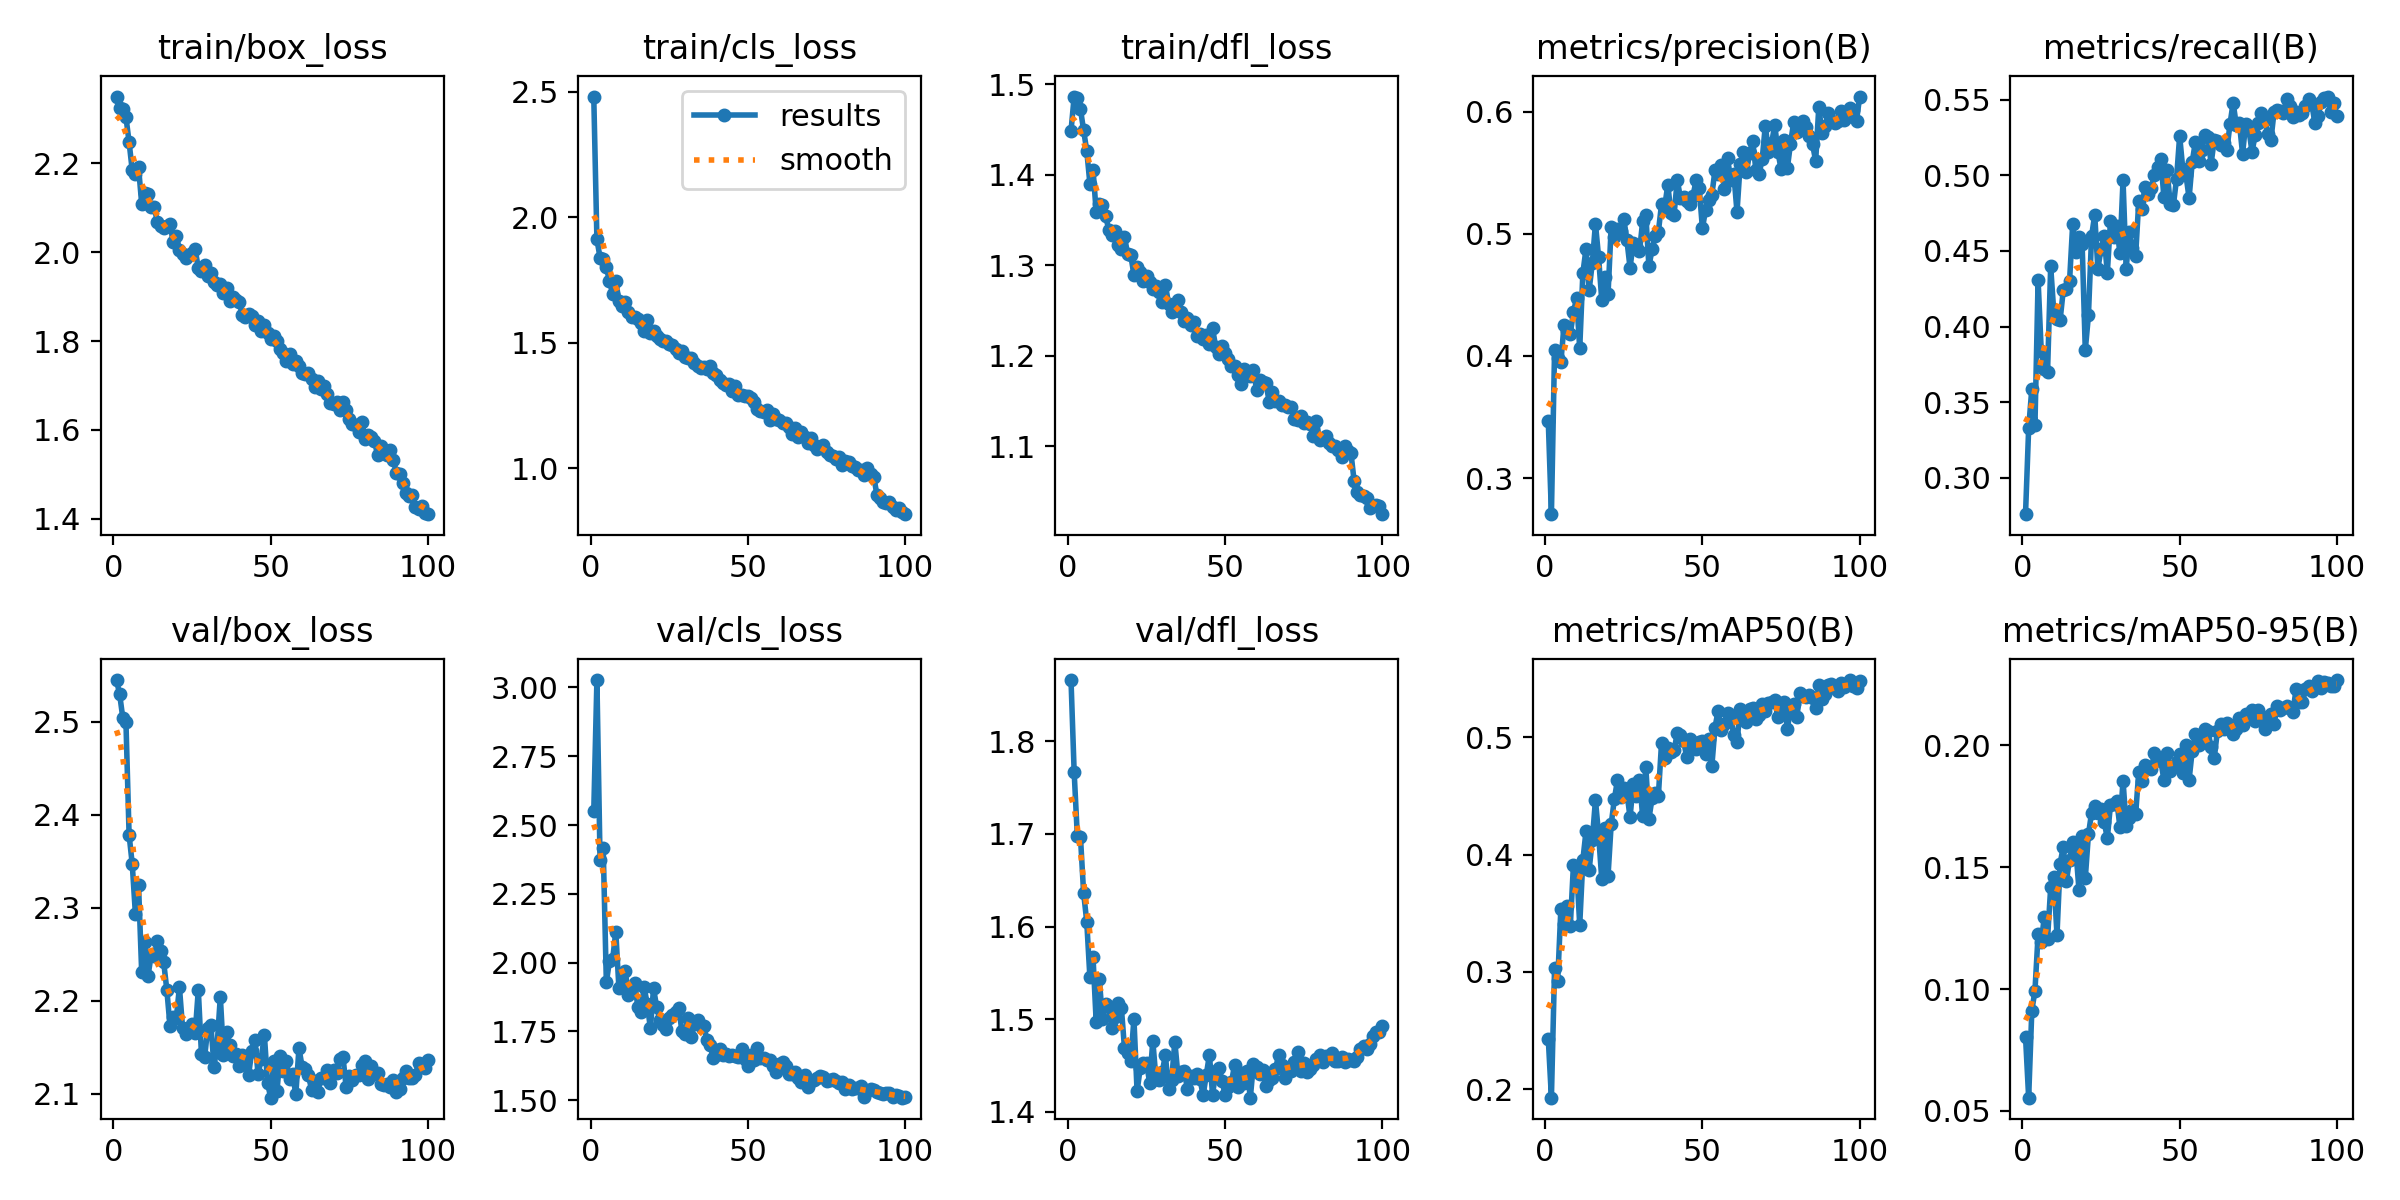

📊 Mostrando: results.png


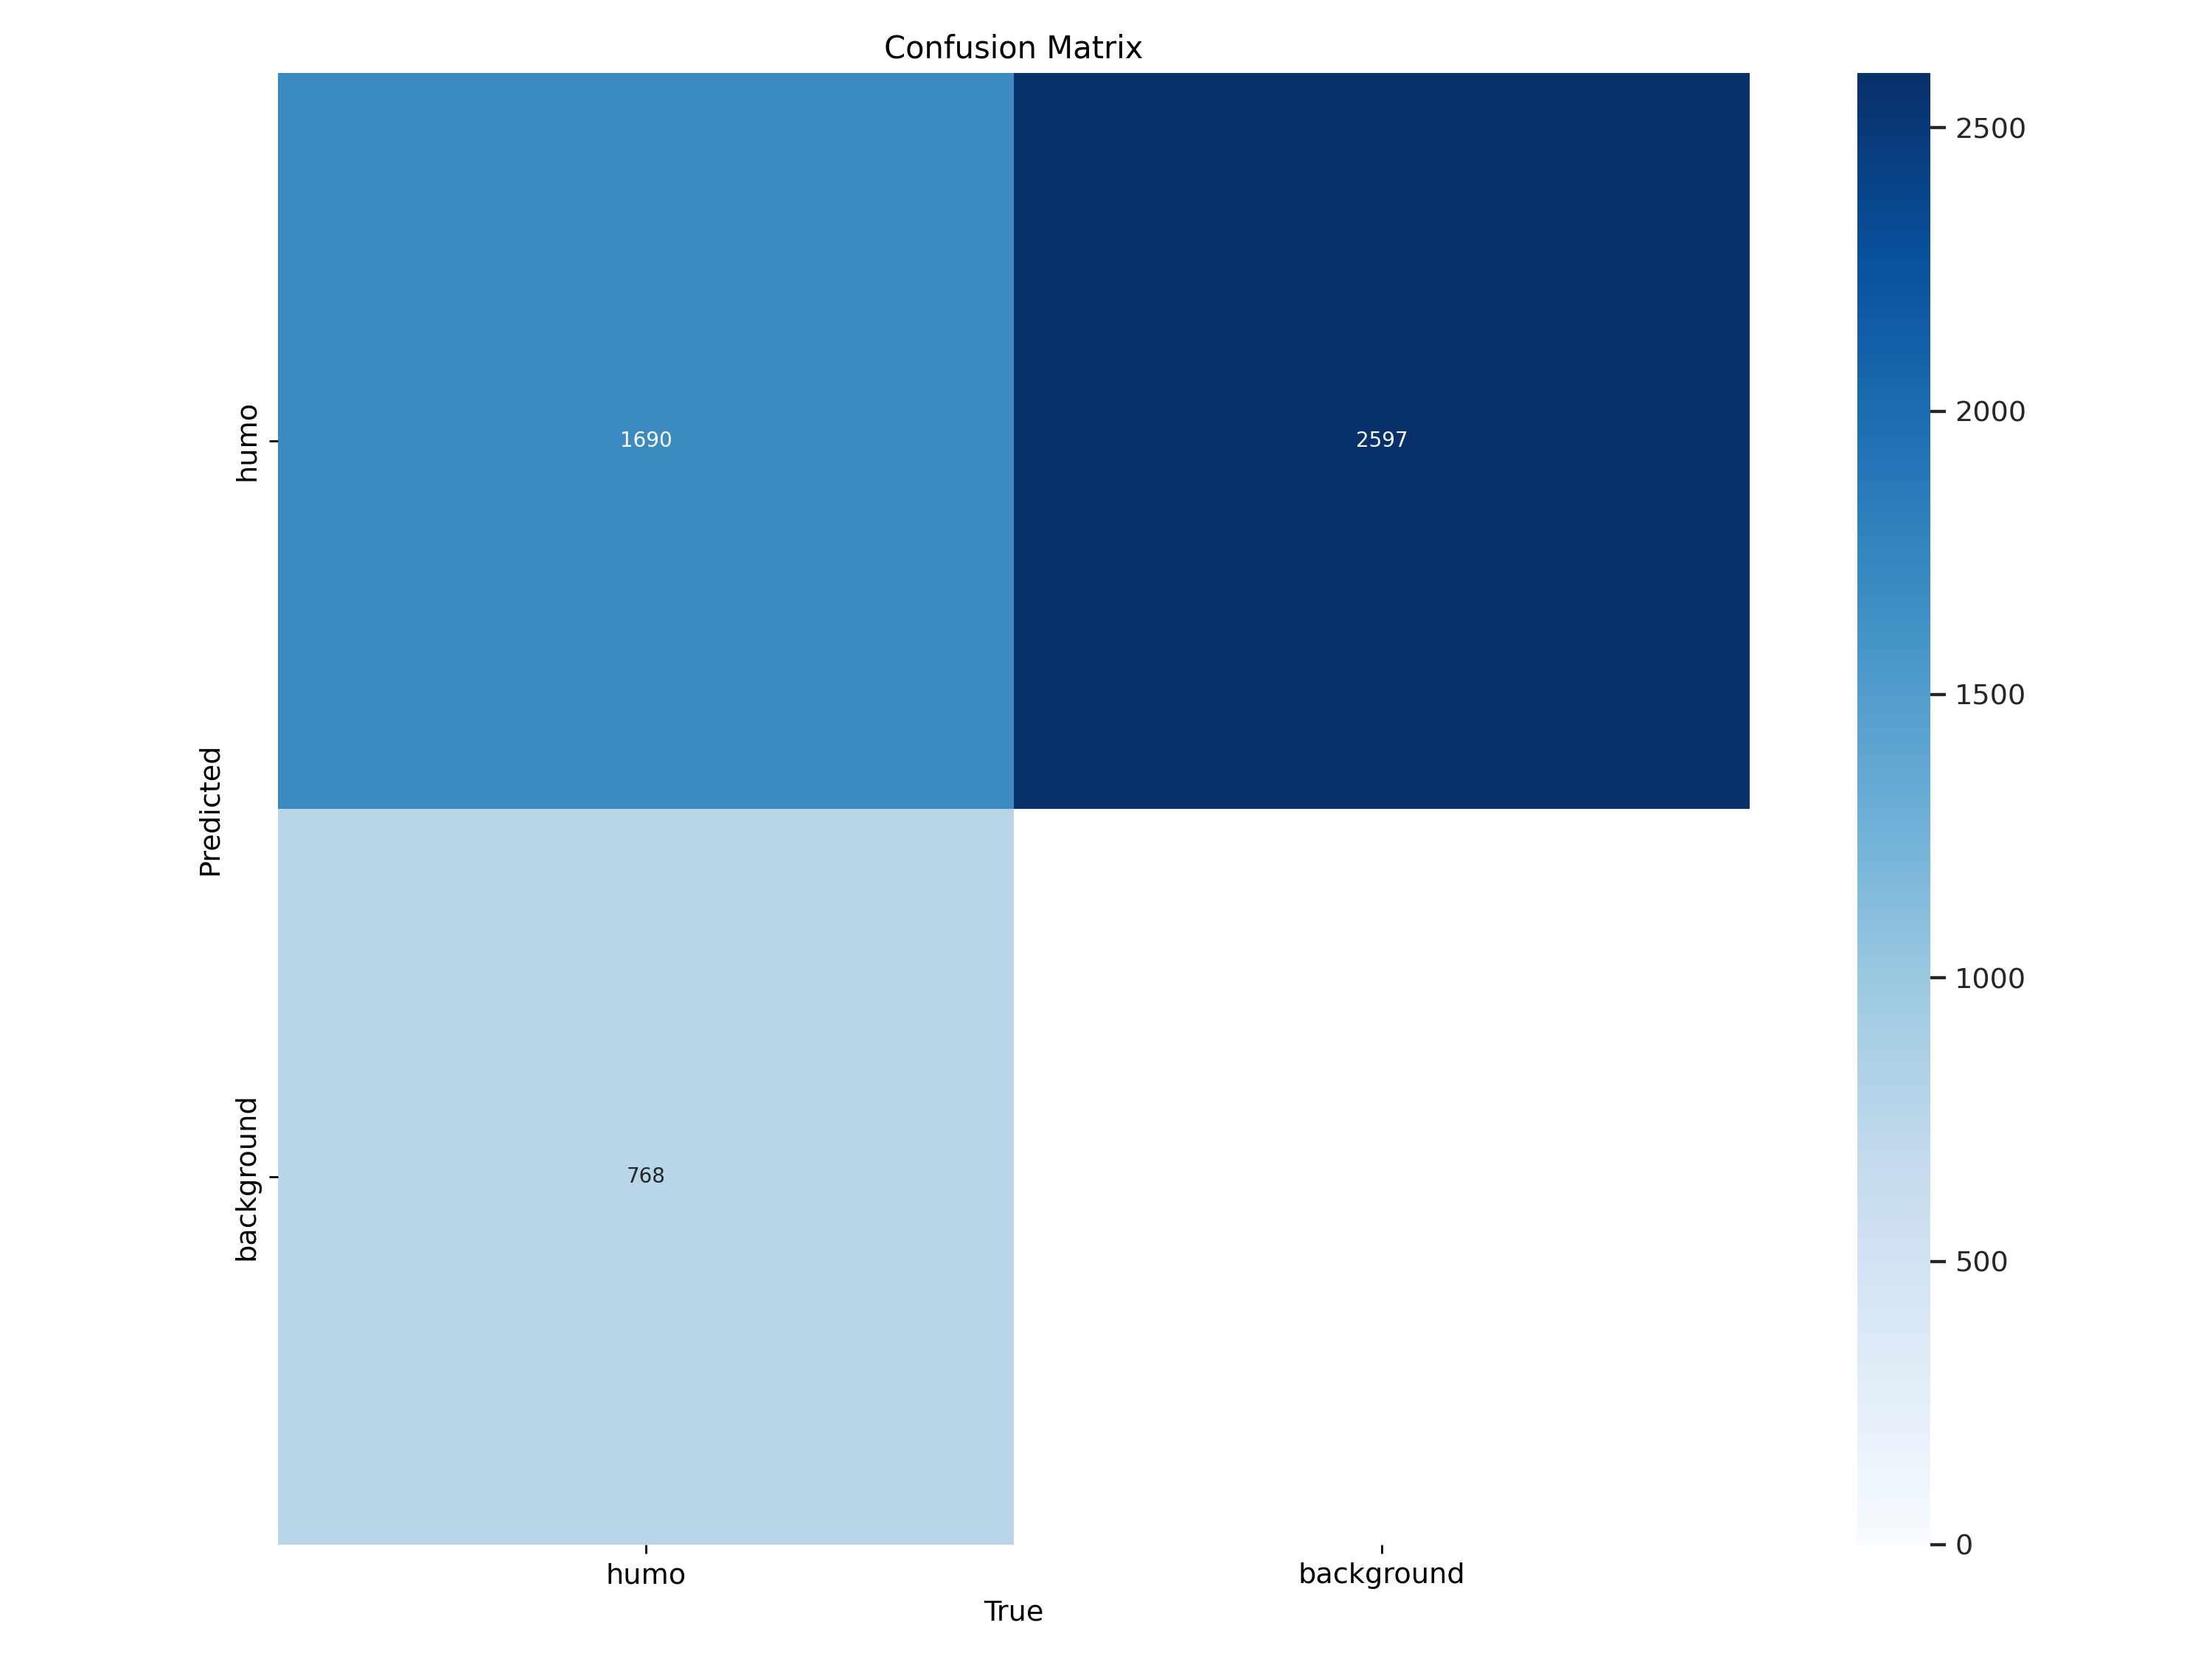

📊 Mostrando: confusion_matrix.png


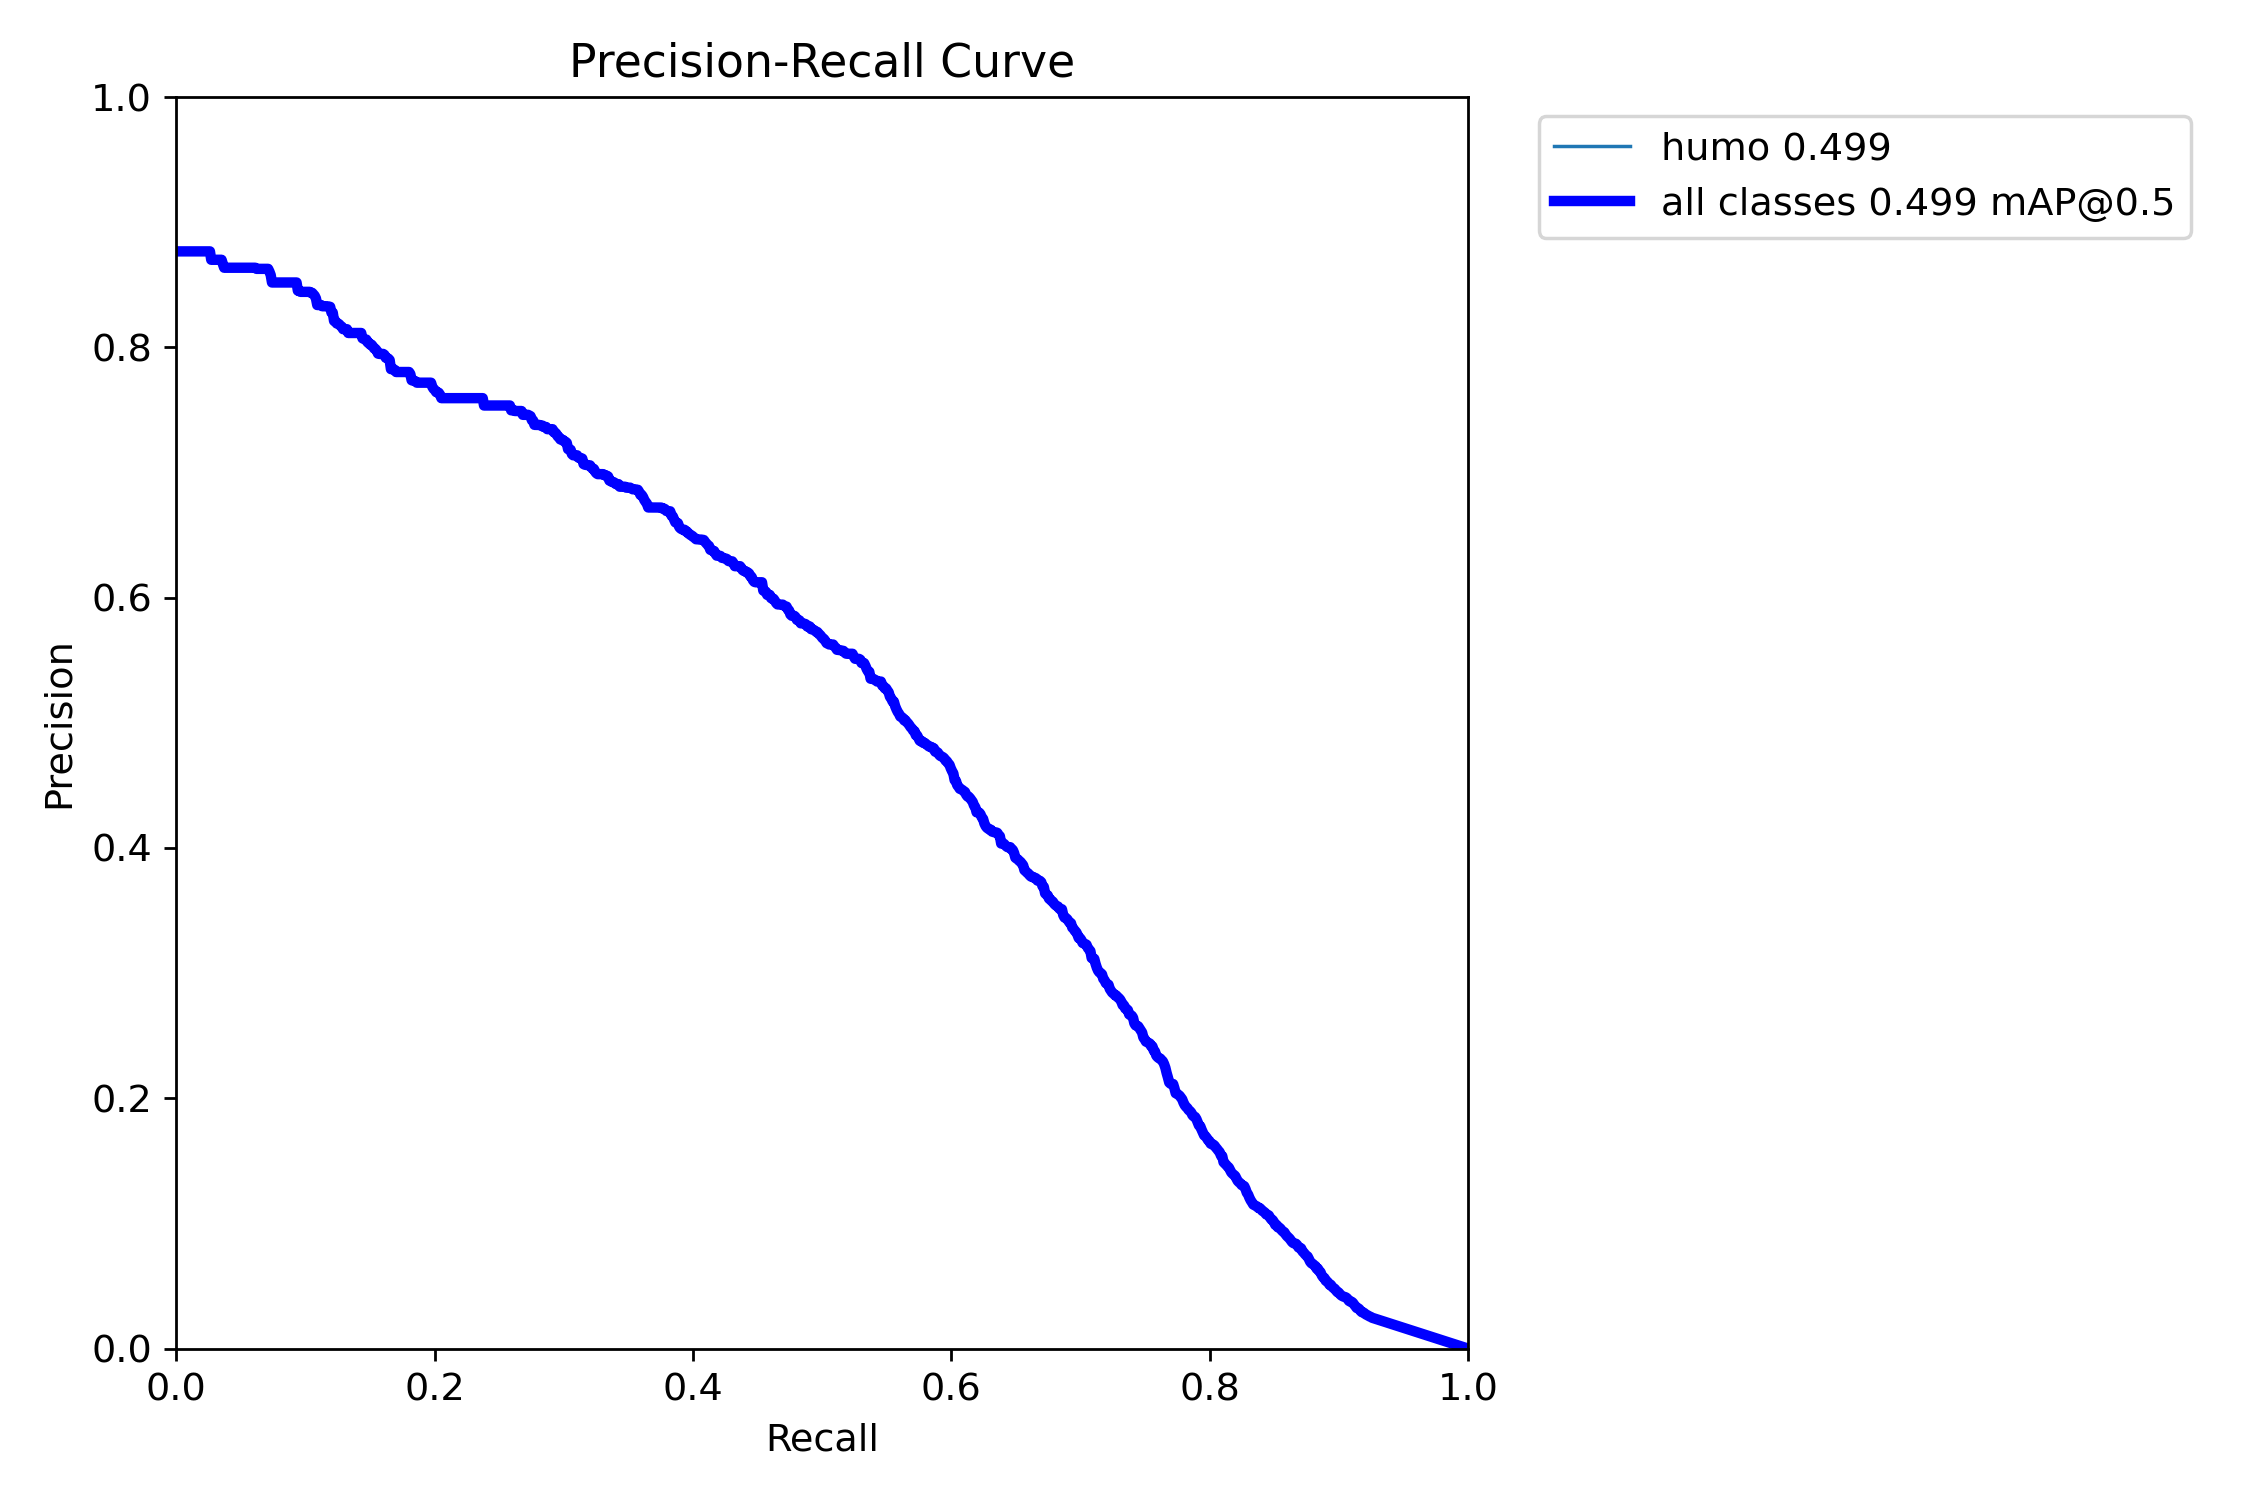

📊 Mostrando: PR_curve.png


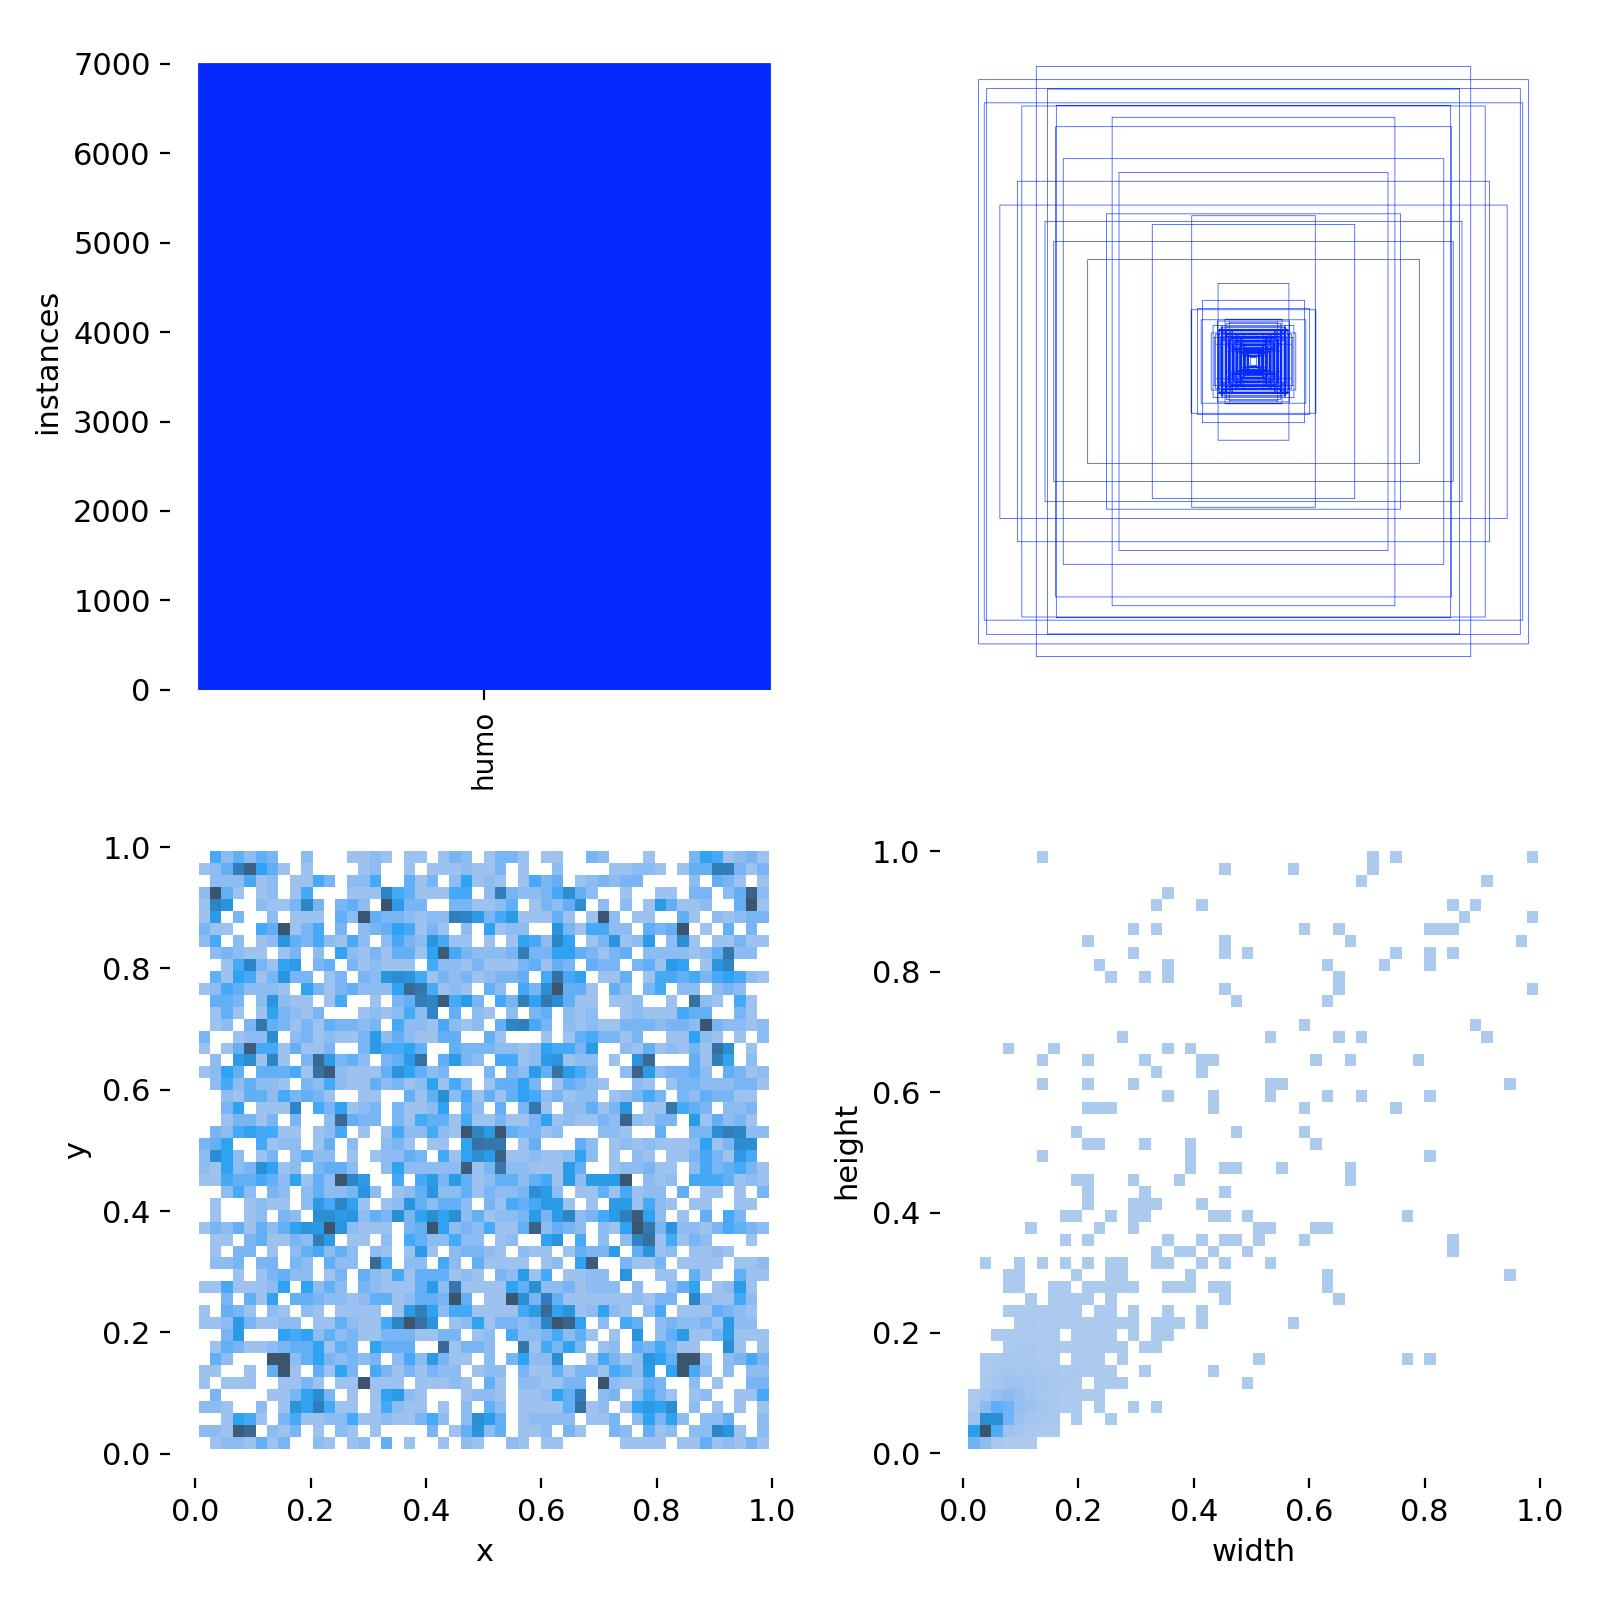

📊 Mostrando: labels.jpg


In [48]:
from IPython.display import Image, display

# Ruta base del experimento (ajustá si usaste otro nombre de run)
base_path = 'runs/detect/wildfire-strong-softaug3/'

# Gráficas generadas por Ultralytics
images = [
    'results.png',             # curvas de loss, precision, recall, mAP
    'confusion_matrix.png',    # matriz de confusión
    'PR_curve.png',            # curva precisión-recall
    'labels.jpg'               # distribución de etiquetas por clase
]

# Mostrar las gráficas disponibles
for img_name in images:
    img_path = base_path + img_name
    display(Image(filename=img_path))
    print(f"📊 Mostrando: {img_name}")